In [393]:
import category_encoders
import datetime
import json
import os
import pickle
import time
import numpy as np
import pandas as pd
import seaborn as sns

import torch

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from scipy.spatial.distance import jensenshannon
from sklearn.metrics import log_loss

import mysql.connector as mysql
from clickhouse_driver import Client

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

def configura():
    return None

In [314]:
!ls cojuntoDeDatosManual

banner.csv


In [406]:
df = pd.read_csv("cojuntoDeDatosManual/2.csv")
df.info()

/tmp/ipykernel_4062036/3949202829.py:1: DtypeWarning: Columns (3,20,21,22,23,24,25,26,31,34,36,38,40,43,44,45,46,48,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("cojuntoDeDatosManual/2.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158430 entries, 0 to 158429
Data columns (total 62 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   158430 non-null  float64
 1   created_ts           158430 non-null  object 
 2   device_devicetype    158419 non-null  float64
 3   device_geo_city      9429 non-null    object 
 4   device_geo_country   158419 non-null  object 
 5   device_geo_region    9537 non-null    float64
 6   device_geo_type      10034 non-null   float64
 7   device_geo_zip       9385 non-null    float64
 8   device_h             0 non-null       float64
 9   device_ip            158417 non-null  object 
 10  device_js            2039 non-null    float64
 11  device_language      71189 non-null   object 
 12  device_make          158419 non-null  object 
 13  device_model         158346 non-null  object 
 14  device_os            158419 non-null  object 
 15  device_osv       

In [407]:
# get chrono
df = df.sort_values(by="created_ts").reset_index(drop=True)

In [409]:
df.device_os.value_counts()

android       102422
windows nt     31083
windows        19780
ios             2810
linux            798
mac os           730
mac os x         546
ubuntu           135
macosx            54
harmonyos         18
tizen             16
osx               12
fedora             8
chrome os          3
freebsd            2
unknown            2
Name: device_os, dtype: int64

In [396]:
def get_weekday(v):  # day of a week matching
    if type(v) == pd._libs.tslibs.timestamps.Timestamp:
        return v.weekday()
    if type(v) == str:
        return datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S').weekday()
    else:
        # utilities.logger.error("Unknown type date")
        print("Unknown type date")


def get_hour(v):  # by-hour periods matching
    if type(v) == pd._libs.tslibs.timestamps.Timestamp:
        return v.hour
    if type(v) == str:
        return datetime.datetime.strptime(v, '%Y-%m-%d %H:%M:%S').hour
    else:
        # utilities.logger.error("Unknown type date")
        print("Unknown type date")

df["weekday"] = df.created_ts.apply(lambda v: get_weekday(v))
df["hour"] = df.created_ts.apply(lambda v: get_hour(v))

In [369]:
non_empty = [feat for feat in df if df[feat].isna().sum()/len(df) < 0.3]
print(len(non_empty))
non_empty

29


['id',
 'created_ts',
 'device_devicetype',
 'device_geo_country',
 'device_ip',
 'device_make',
 'device_model',
 'device_os',
 'device_osv',
 'device_ua',
 'imp_banner_h',
 'imp_banner_w',
 'imp_bidfloor',
 'imp_tagid',
 'site_cat',
 'site_domain',
 'site_id',
 'site_page',
 'site_publisher_id',
 'site_traffic_type',
 'ssp_id',
 'seatbid_bid_cid',
 'seatbid_bid_crid',
 'is_view',
 'showcase_id',
 'template_id',
 'count_template_slot',
 'weekday',
 'hour']

In [370]:
non_singles = [feat for feat in non_empty if df[feat].nunique() > 1]
non_singles

['id',
 'created_ts',
 'device_devicetype',
 'device_ip',
 'device_make',
 'device_model',
 'device_os',
 'device_osv',
 'device_ua',
 'imp_banner_h',
 'imp_banner_w',
 'imp_bidfloor',
 'imp_tagid',
 'site_cat',
 'site_domain',
 'site_id',
 'site_page',
 'site_publisher_id',
 'site_traffic_type',
 'ssp_id',
 'seatbid_bid_cid',
 'seatbid_bid_crid',
 'is_view',
 'showcase_id',
 'template_id',
 'count_template_slot',
 'weekday',
 'hour']

In [397]:
configura.features = {
    'device_devicetype': "object",
    'device_make': "object",
    'device_model': "object",
    'device_os': "object",
    'device_osv': "object",
    'imp_tagid': "object",
    'site_domain': "object",
    'site_id': "object",
    'site_publisher_id': "object",
    'site_traffic_type': "object",
    "ssp_id": "object",
    'seatbid_bid_crid': "object",
    'template_id': "object",
    'count_template_slot': "object",
    "hour": "object"
}

configura.target = {"is_click": "bool"}

In [398]:
# drop incorrect records
df = df[df.is_view == 1].reset_index(drop=True)
print(df.shape)

(138773, 64)


In [295]:
# n = 14
# f = [x for x in configura.features][n]
# print(f)
# print(f"{df[f].isna().sum()/len(df) :.5f}")
# df[f].value_counts()


In [399]:
# rare items -> other category
objects = [k for k,v in configura.features.items() if v == "object"]

for f in objects:
    feature_counts = df[f].value_counts()
    not_sufficient = list(feature_counts[feature_counts < 50].keys())
    df.loc[df[f].isin(not_sufficient), f] = "other"

In [400]:
def objects_processing(v):
    '''check if float in an object feature -> cut fraction'''
    try:
        v = str(int(float(v)))
    except ValueError:
        v = str(v)

    return v.lower()

def post_process(df):
    start_time = time.time()
    print(f"preshape: {df.shape}")
    # utilities.logger.info("post processing started...")
    print("post processing started...")

    df = df[list(configura.features.keys()) + list(configura.target.keys())]
    
    obj_cols = [k for k, v in configura.features.items() if v=="object"]
    int_cols = [k for k, v in configura.features.items() if "int" in v]
    float_cols = [k for k, v in configura.features.items() if "float" in v]
    bool_cols = [k for k, v in configura.features.items() if v=="bool"]
    bool_cols += [k for k, v in configura.target.items() if v=="bool"] #TODO

    df_trans = df.copy()
    df_trans[obj_cols] = df[obj_cols].fillna("-1")
    df_trans[int_cols+float_cols] = df[int_cols+float_cols].fillna(-1)
    df_trans[bool_cols] = df[bool_cols].fillna(0)
    
    for f in obj_cols:
        df_trans[f] = df_trans[f].apply(objects_processing)
    df_trans[int_cols+bool_cols] = df_trans[int_cols+bool_cols].astype(int)
    df_trans[float_cols] = df_trans[float_cols].astype(float)

    # utilities.logger.info(
    #     f"post processing completed, time : {int(time.time() - start_time)}s, shape: {df.shape}"
    # )
    # utilities.logger.info(f"...post processing target counts: {df[config.features_dict['target'].keys()].value_counts()}")
    print(
        f"post processing completed, time : {int(time.time() - start_time)}s, shape: {df.shape}"
    )
    print(f"...post processing target counts:\n{df_trans[configura.target.keys()].value_counts()}")
    print(f"posthape: {df_trans.shape}")

    return df_trans

df = post_process(df)

preshape: (138773, 64)
post processing started...
post processing completed, time : 1s, shape: (138773, 16)
...post processing target counts:
is_click
0           138647
1              126
dtype: int64
posthape: (138773, 16)


In [401]:
def fit_encoder(df, encoder_type="target"):
    object_columns = [k for k,v in configura.features.items() if v=="object"]
    if encoder_type == "target":
        encoder = category_encoders.target_encoder.TargetEncoder(return_df=False)
    elif encoder_type == "catboost":
        encoder = category_encoders.cat_boost.CatBoostEncoder(return_df=False)
    elif encoder_type == "woe":
        encoder = category_encoders.woe.WOEEncoder(return_df=False)    
    encoder.fit(
        df[object_columns].copy().values,
        df[configura.target.keys()].copy().values
    )

    return encoder

def encode_objects(df, encoder):

    df[[k for k,v in configura.features.items() if v=="object"]] = encoder.transform(
        df[[k for k,v in configura.features.items() if v=="object"]].copy().values
    )


    return df

def fit_scaler(df, scaler_type="standard"):
    if scaler_type == "standard":
        scaler = preprocessing.StandardScaler()
    if scaler_type == "minmax":
        scaler = preprocessing.MultiLabelBinarizer()
    if scaler_type == "maxabs":
        scaler = preprocessing.MaxAbsScaler()
    scaler.fit(df.drop(configura.target.keys(), axis=1))

    # pickle.dump(scaler, open(config.scaler_path, 'wb'))

    return scaler

def scale_data(df, scaler):

    df = pd.concat([
        pd.DataFrame(
            scaler.transform(df.drop(configura.target.keys(), axis=1)),
                columns = df.drop(configura.target.keys(), axis=1).columns
            ).reset_index(drop=True),
            df[configura.target.keys()].reset_index(drop=True)], axis=1)


    return df 

encoder = fit_encoder(df)
df = encode_objects(df, encoder)

scaler = fit_scaler(df)
df = scale_data(df, scaler)

In [402]:
dftr = df.iloc[:int(len(df)*0.8), :]
dfts = df.iloc[int(len(df)*0.8):, :]
print(dftr.shape, dfts.shape)
print(dftr.is_click.value_counts())
print(dfts.is_click.value_counts())

(111018, 16) (27755, 16)
0    110928
1        90
Name: is_click, dtype: int64
0    27719
1       36
Name: is_click, dtype: int64


Epoch 001/008: | Loss: 0.06651 | Acc: 97.925| Valid_Loss: 0.00001 | Valid_Acc: 0.461 | Time: 40.1
Epoch 002/008: | Loss: 0.00686 | Acc: 99.896| Valid_Loss: 0.00000 | Valid_Acc: 0.461 | Time: 40.3
Epoch 003/008: | Loss: 0.00654 | Acc: 99.896| Valid_Loss: 0.00000 | Valid_Acc: 0.461 | Time: 40.4
Epoch 004/008: | Loss: 0.00662 | Acc: 99.898| Valid_Loss: 0.00000 | Valid_Acc: 0.461 | Time: 40.4
Epoch 005/008: | Loss: 0.00625 | Acc: 99.896| Valid_Loss: 0.00000 | Valid_Acc: 0.461 | Time: 40.2
Epoch 006/008: | Loss: 0.00622 | Acc: 99.896| Valid_Loss: 0.00000 | Valid_Acc: 0.461 | Time: 40.7
Epoch 007/008: | Loss: 0.00617 | Acc: 99.899| Valid_Loss: 0.00000 | Valid_Acc: 0.461 | Time: 40.4
Epoch 008/008: | Loss: 0.00612 | Acc: 99.897| Valid_Loss: 0.00000 | Valid_Acc: 0.461 | Time: 40.1
model fit completed


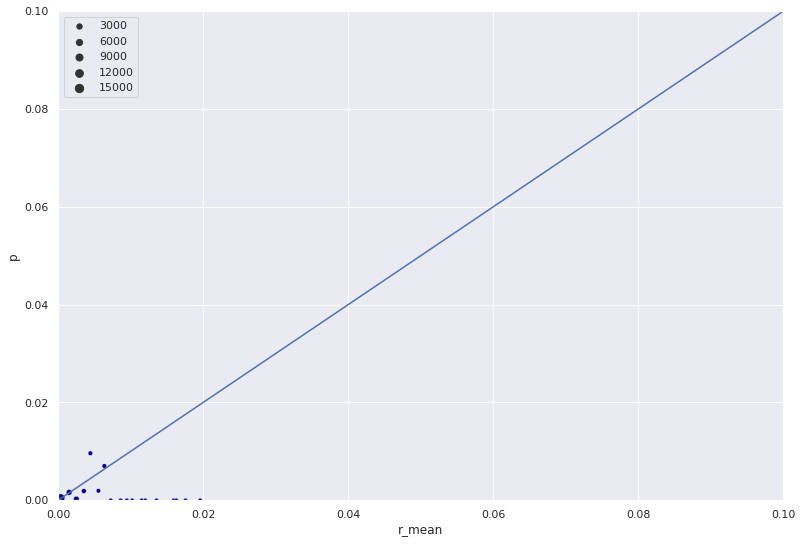

In [403]:
configura.batch_size = 64
configura.epochs = 8
configura.learning_rate = 0.001
configura.test_params = [1000, 5, 0.1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyDataset(torch.utils.data.Dataset):   
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

def get_loader(df, shuffle_bool=False):
    data = MyDataset(
        torch.FloatTensor(df.drop(configura.target.keys(), axis=1).to_numpy()),
        torch.FloatTensor(df[configura.target.keys()].to_numpy()),
    )
    loader = torch.utils.data.DataLoader(
        dataset=data, batch_size=configura.batch_size, shuffle=shuffle_bool
    )

    return loader

def binary_acc(y_pred: np.array, y_test: np.array) -> float:
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def torch_fit(nn, train_loader, test_loader): 

    model = nn
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=configura.learning_rate)

    stats = {"loss_train":[], "loss_valid":[], "accuracy_train":[], "accuracy_valid":[]}

    for e in range(1, configura.epochs+1):
        epoch_loss, epoch_acc = 0, 0
        valid_loss, valid_acc = 0, 0
        st_tm = time.time()
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            acc = binary_acc(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        model.eval()
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = model(x_batch)
            valid_loss = criterion(y_pred, y_batch)
            valid_acc = binary_acc(y_pred, y_batch)

            valid_loss += valid_loss.item()
            valid_acc += valid_acc.item()
        
        stats["loss_train"].append(epoch_loss)
        stats["loss_valid"].append(valid_loss)
        stats["accuracy_train"].append(epoch_acc)
        stats["accuracy_valid"].append(valid_loss)

        print(
            f"Epoch {e+0:03}/{configura.epochs+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}"\
            f"| Valid_Loss: {valid_loss/len(test_loader):.5f} | Valid_Acc: {valid_acc/len(test_loader):.3f} "\
            f"| Time: {time.time() - st_tm:.1f}"
        )

    print("model fit completed")

    return model

def get_preds(model, loader, name):

    probs = []
    for x in loader:
        r = x[0].to(device)
        with torch.no_grad():
            probs.append(torch.sigmoid(model(r.to(device)).detach().cpu()).numpy())    
    probs = [l.squeeze().tolist() for sl in probs for l in sl]
    
    return pd.Series(probs, name=name)

def evaluate_torch_model(model, test_loader):

    model.eval()

    facts = [int(l) for sl in [v[1] for v in iter(test_loader)] for l in sl]
    facts = pd.Series(facts, name=list(configura.target.keys())[0])
    probs = pd.concat([get_preds(model, test_loader, 'r').reset_index(drop=True), facts.reset_index(drop=True)], axis=1)

    n_bins, n_dec, border = configura.test_params
    probs = probs.round({"r":n_dec})
    probs['group'] = pd.cut(
        probs.r, 
        n_bins, 
        right=True,
    ).astype(str)    
    
    # get averages
    probs_to_plot = pd.DataFrame()
    probs_to_plot['r_mean'] = probs.groupby(by='group').mean()['r']
    probs_to_plot['p'] = probs.groupby(by='group').mean()[list(configura.target.keys())]

    # get quantity
    probs_to_plot['n'] = probs.groupby(by='group').count()['r']

    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(13, 9)})
    g = sns.scatterplot(
        x='r_mean', y='p', data=probs_to_plot,
        color = 'darkblue',
        size = probs_to_plot['n'].values
    )
    g.plot(np.linspace(0, border, 100), np.linspace(0, border, 100))
    g.set(xlim=(0, border), ylim=(0, border))

    resulting_metrics = {
        "mae": round(sum(abs(probs_to_plot.p - probs_to_plot.r_mean))/len(probs_to_plot),5),
        "mse": round(sum((probs_to_plot.p - probs_to_plot.r_mean) ** 2)/ len(probs_to_plot),5),
        "jensen_shannon": jensenshannon(probs_to_plot.p , probs_to_plot.r_mean),
        "r_mean": probs.r.mean(),
        "p_mean": facts.mean(),
        "means_positive": probs[probs[list(configura.target.keys())[0]]==1].r.mean(),
        "means_negative": probs[probs[list(configura.target.keys())[0]]==0].r.mean(),
        "prediction_range": probs.r.max()-probs.r.min(),
        "log_loss": log_loss(facts, probs.r)
    }

    return probs, resulting_metrics


class NnClickBanner(torch.nn.Module):
    def __init__(self, ninput):
        super(NnClickBanner, self).__init__()
        self.layer_1 = torch.nn.Linear(ninput, 2048) 
        self.layer_2 = torch.nn.Linear(2048, 1024) 
        self.layer_3 = torch.nn.Linear(1024, 512)
        self.layer_4 = torch.nn.Linear(512, 128)
        self.layer_5 = torch.nn.Linear(128, 64)
        self.layer_out = torch.nn.Linear(64, 1) 
        
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.2)
        self.batchnorm1 = torch.nn.BatchNorm1d(2048)
        self.batchnorm2 = torch.nn.BatchNorm1d(1024)
        self.batchnorm3 = torch.nn.BatchNorm1d(512)
        self.batchnorm4 = torch.nn.BatchNorm1d(128)
        self.batchnorm5 = torch.nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

train_loader = get_loader(dftr, True)
test_loader = get_loader(dfts)
ninput = next(iter(train_loader))[0].shape[1]
model = torch_fit(NnClickBanner(ninput), train_loader, test_loader)

probabilities, resulting_metrics = evaluate_torch_model(
    model, test_loader
)

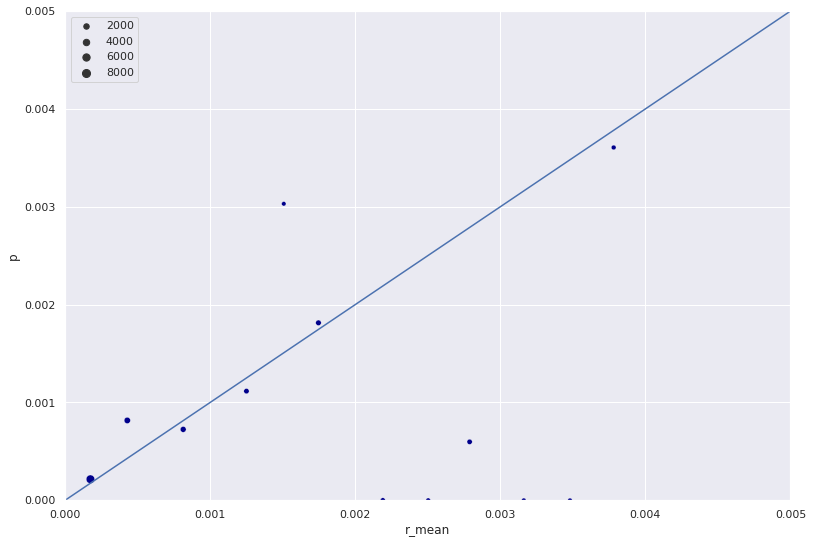

In [404]:
configura.test_params = [3000, 5, 0.005]
probabilities, resulting_metrics = evaluate_torch_model(
    model, test_loader
)


In [405]:
!ls dicts

creds.json  features_dictionary.json
